In [1]:
#Script to segment flow images. It requires 4 data sets: 1: the dry image for registration, 2: the flow image, 3: the wet image, and 4: the segmented dry scan 

#files needed to run the processing. NB utils is a package that Dane helped me make. It includes some important functions in it. 
import utils
import skimage
import numpy as np
import matplotlib.pyplot as plt
import PIL
from PIL import Image, ImageDraw

#non-local means filter 
from skimage import data, img_as_float, img_as_ubyte, exposure
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.metrics import peak_signal_noise_ratio

#registration
from skimage.registration import phase_cross_correlation
from skimage.registration._phase_cross_correlation import _upsampled_dft

#dealing with saving tif files 
import os
import tifffile as tif
import ipywidgets as widgets


# Dry scan needed for registration 

In [7]:
# note we are loading in fewer slices to save memory, it seems sufficient, but could be changed
# can we apply the same transform once we know what the reference is? This will save computation 


# Read the TIFF images for the dry scan 
dirname     = 'E:\\New reconstructions\\merged\\merged\\05_dry_bin2_merged'
start_slice = 600 #780 for middle section
slices      = 100 #change this is you want to load in more slices NB python starts from 0 


dry_data = utils.load(dirname, start_slice=start_slice, slices=slices)



MemoryError: Unable to allocate 11.7 GiB for an array with shape (200, 2800, 2800) and data type float64

### Load wet scan (flow done in the loop later on)

In [4]:


dirname =  'E:\\New reconstructions\\merged\\merged\\07_wet_bin2_merged'
wet_data =  utils.load(dirname, start_slice=start_slice, slices=slices)



(100, 1400, 1400)


### Crop to a cylinder (can change size here)

In [3]:
#NB this code can be edited to change the location and centre of the cylinder for the cropping 

def crop(img):
    z, h, w = img.shape
    
    # creating cylindrical mask
    lum_img = Image.new('L', [h, w], 0)
    draw = ImageDraw.Draw(lum_img)
    draw.pieslice([(135, 90), (h-75, w-75)], 0, 360, fill=255)  #change values here to change the mask shape 
    mask = np.array(lum_img)
    mask = np.repeat(mask[np.newaxis, :, :], z, axis=0)
    mask = (mask == 0)

    assert img.shape == mask.shape
    assert mask.dtype == np.bool8

    foreground = img.copy()
    foreground[mask] = 255

    return foreground

NameError: name 'wet_data' is not defined

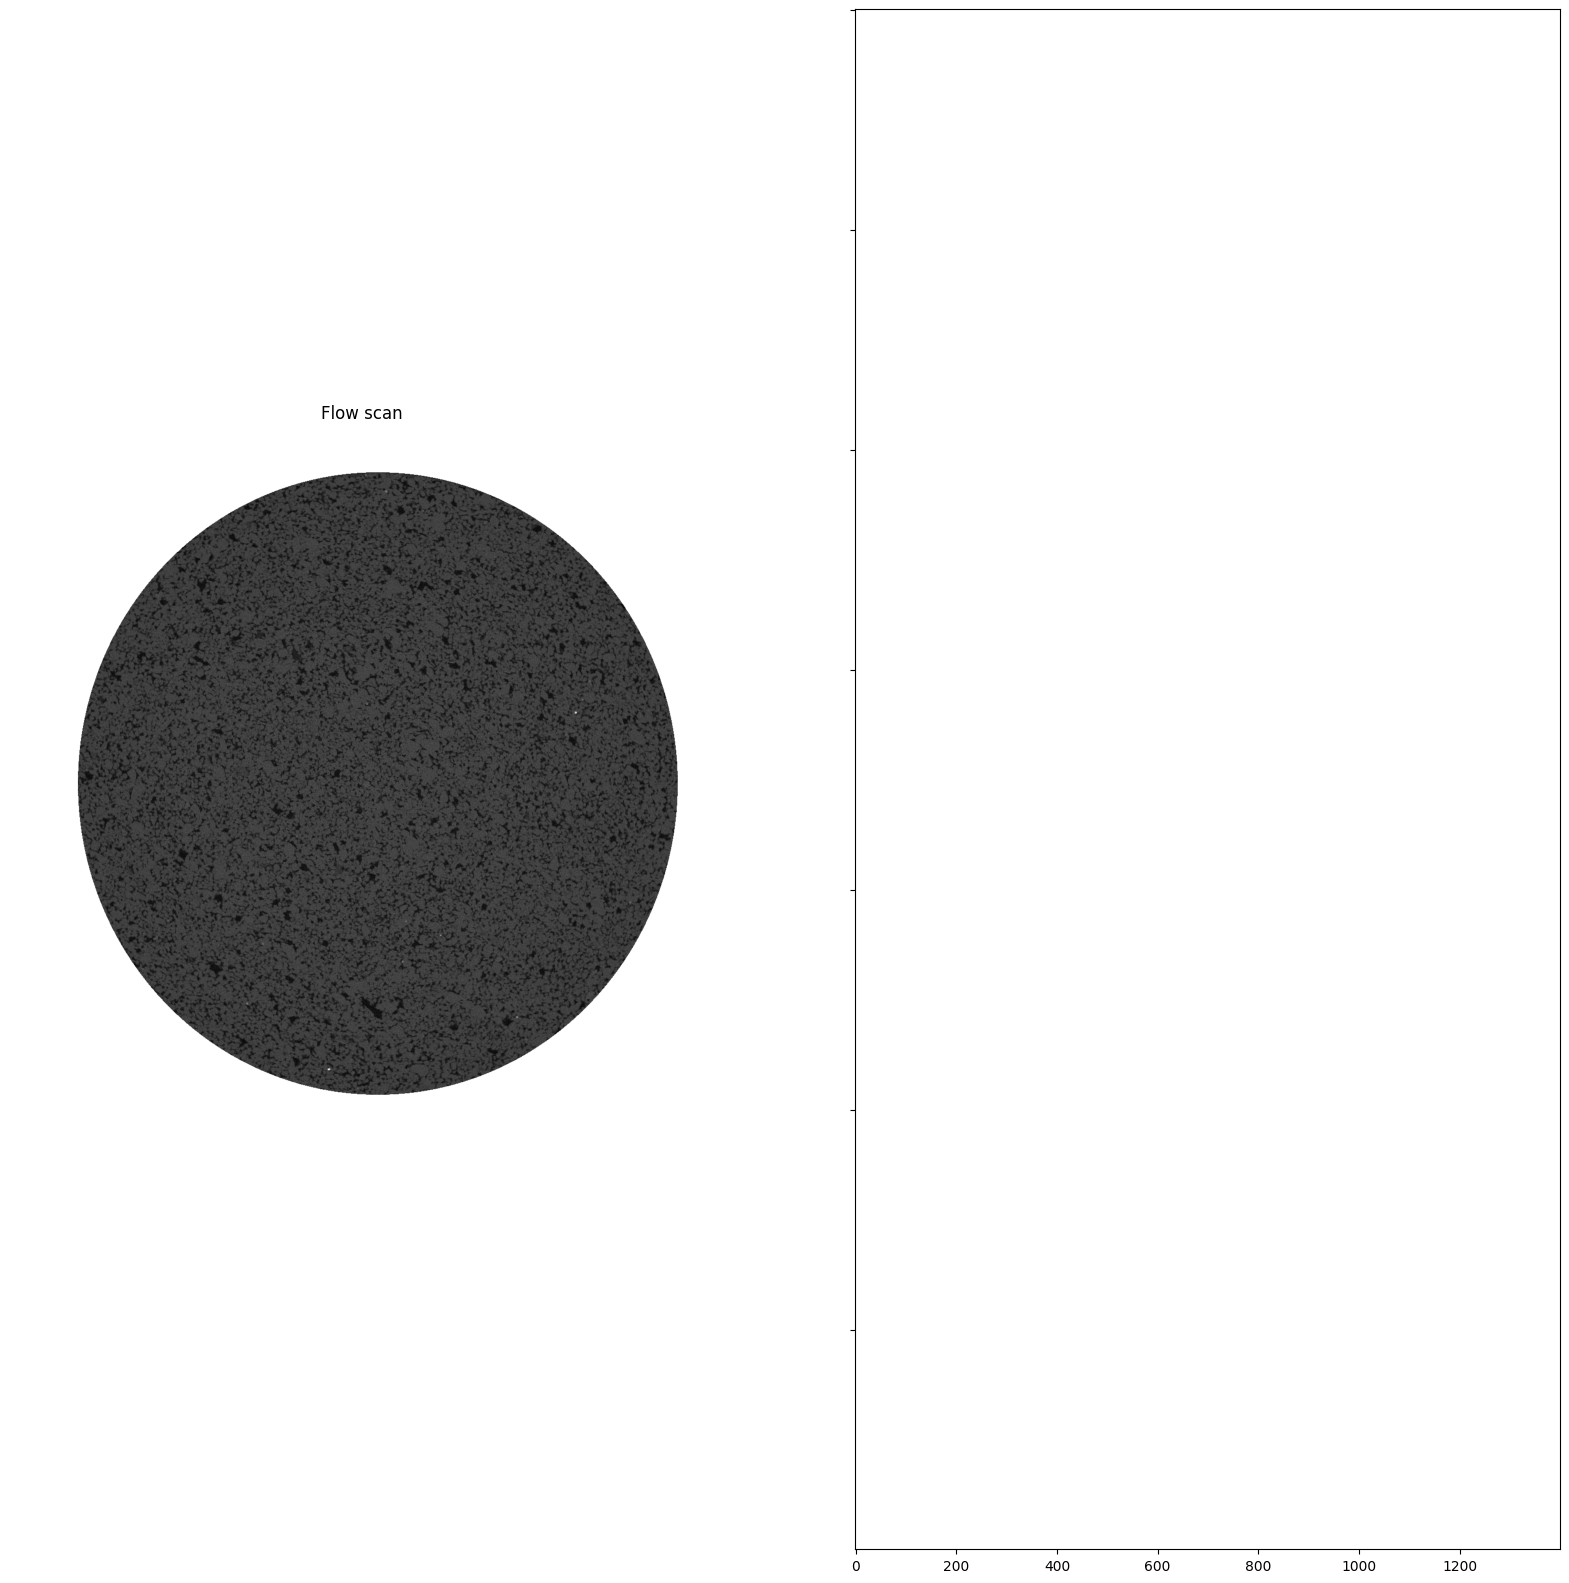

In [4]:
# The images are cropped into a cylinder (so that we aren't including the outer sleeve in the analysis) 
#wet_data  = crop(wet_data)
dry_data  = crop(dry_data)

#NB lots of data overwriting at this point to preserve memory 

#Check the cropping 
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 20),
                       sharex=True, sharey=True)

ax[0].imshow(dry_data[10, :, :],cmap='gray')
ax[0].axis('off')
ax[0].set_title('Flow scan')


ax[1].imshow(wet_data[10,:, :],cmap='gray')
ax[1].axis('off')
ax[1].set_title('Wet scan')

fig.tight_layout()
plt.show()

### Filtering and registration 

In [15]:
#filter the images prior to registration

#non-local means filter works better on float of image with no exposure or histogram modification.
dry_float  = dry_data.astype(np.float32)
wet_float  = wet_data.astype(np.float32)
del dry_data # this is done to minmise memory usage 
del wet_data

def nlm_denoise(Img,patch,dist):
    
    def nlm_denoise_wrap(array):
        correct=img_as_float(array[0])
        sigma_est = np.mean(estimate_sigma(correct))
        correct = denoise_nl_means(correct, h=3 * sigma_est, sigma=sigma_est,fast_mode=True,patch_size=patch, patch_distance=dist)
        return correct[np.newaxis, ...]
    
    denoise=skimage.util.apply_parallel(nlm_denoise_wrap,Img, chunks=(1, Img.shape[1],Img.shape[2]), dtype='float',compute=True)
    
    return  denoise

denoise_dry = nlm_denoise(dry_float, patch = 3,  dist = 6)

#denoise_wet = nlm_denoise(wet_float, patch = 3,  dist = 6)
#del wet_float






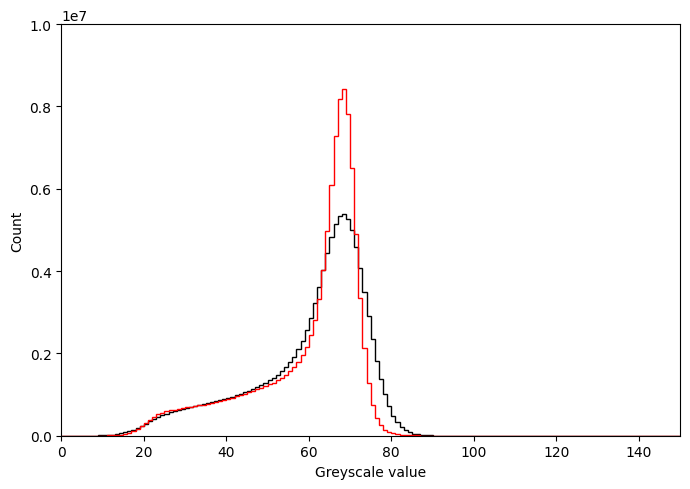

In [16]:
denoise_dry  = utils.preprocess(denoise_dry.astype(np.uint8))
#denoise_wet  = utils.preprocess(denoise_wet.astype(np.uint8))


#plot of the histograms (entire image, not the zoomed in image)
bins=255
fig, ax = plt.subplots(figsize =(7, 5))
ax.set_xlabel('Greyscale value')
ax.set_ylabel('Count')

ax.set_xlim(0, 150) 
ax.set_ylim(0, 10**7) 

ax.hist(dry_float.ravel(), bins=bins, histtype='step', color='black')
ax.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))

ax.hist(denoise_dry.ravel(), bins=bins, histtype='step', color='red')
ax.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))

fig.tight_layout()
plt.show()

#del dry_float


Shift in Z direction for wet scan 0.0


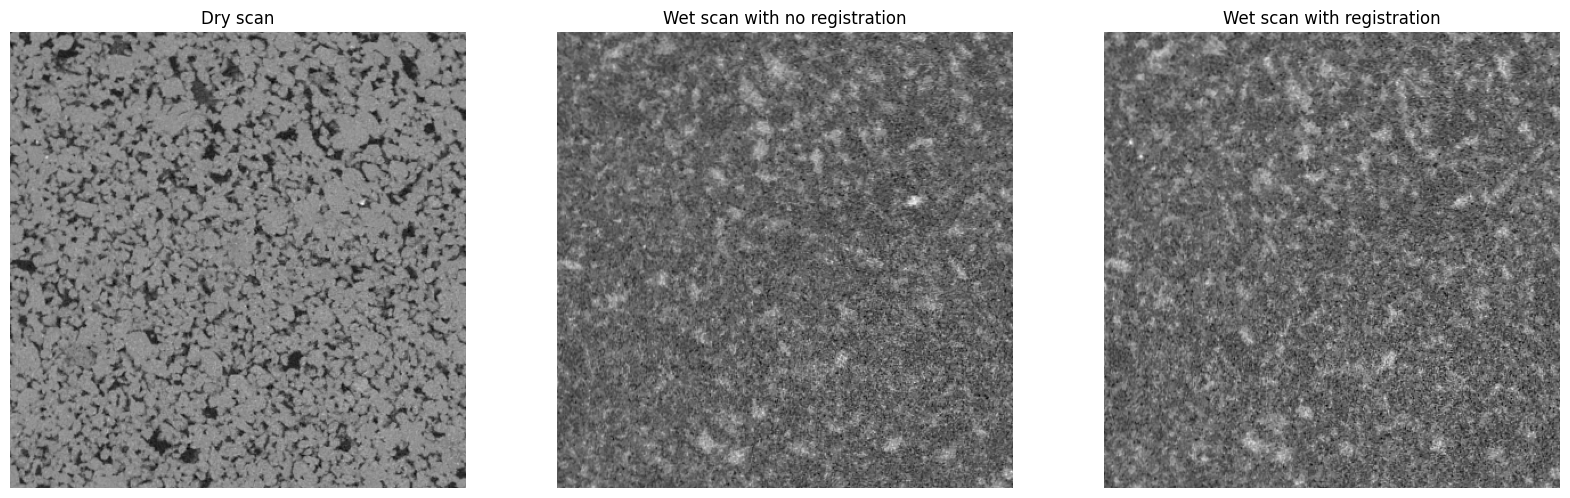

In [9]:
#registration 
# pixel precision 
shift_wet, error_wet, diffphase_wet = phase_cross_correlation(denoise_dry[5:55:,200:1100, 200:1100], denoise_wet[5:55,200:1100, 200:1100])
print('Shift in Z direction for wet scan', shift_wet[0])
#Check the registration 
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 20),
                       sharex=True, sharey=True)

ax[0].imshow(denoise_dry[10,400:800, 400:800],cmap='gray')
ax[0].axis('off')
ax[0].set_title('Dry scan')


ax[1].imshow(denoise_wet[10,400:800, 400:800],cmap='gray')
ax[1].axis('off')
ax[1].set_title('Wet scan with no registration')

ax[2].imshow(denoise_wet[10 +2 ,400:800, 400:800],cmap='gray')
ax[2].axis('off')
ax[2].set_title('Wet scan with registration')
plt.show()

#simple 3D shift, no resampling of the axes needed with this, but could be adapted 

denoise_wet_reg  = denoise_wet[(10 + 2):, :, :] 
del denoise_wet

### Filter and register the flow images separately so we can loop over this part separately 

In [10]:
directory = 'E:\\New reconstructions\\merged\\merged\\'

folders = (os.listdir(directory))
folders = folders[2:-1]

print(folders[0])

09_h2lh_merged


Shift in Z direction for flow scan [-2.  0.  0.]


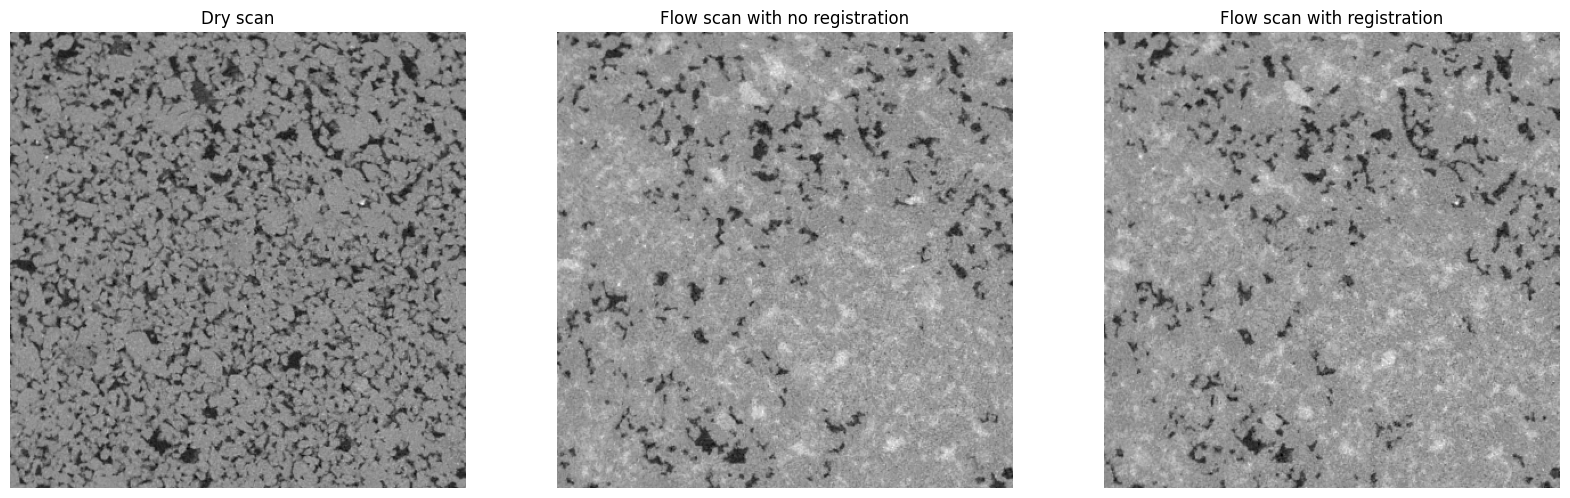

In [12]:


for i in [0]:
    flow_dirname = 'E:\\New reconstructions\\merged\\merged\\' + folders[i]


  
    flow_data = []

    fname = (os.listdir(flow_dirname))
    for j in range(start_slice, start_slice + slices):
        im = Image.open(os.path.join(flow_dirname, fname[j]))
        imarray = np.array(im)
        flow_data.append(imarray)


    # convert to a 3D array and normalise so data is between 0 and 1 
    flow_data  = np.asarray(flow_data) 
    flow_data = utils.preprocess(flow_data.astype(np.float32))


    #filtering
    flow_data = crop(flow_data)
    flow_float = flow_data.astype(np.float32)
    del flow_data
    denoise_flow = nlm_denoise(flow_float, patch = 3,  dist = 6)
    del flow_float
    denoise_flow = utils.preprocess(denoise_flow.astype(np.uint8))

    #registration
    shift, error, diffphase = phase_cross_correlation(denoise_dry[1:50,:, :], denoise_flow[1:50,:, :])
    print('Shift in Z direction for flow scan', shift)


    denoise_flow_reg = denoise_flow[(10 - int(shift[0])): denoise_wet_reg.shape[0] + 1, :, :] 
    del(denoise_flow)

    #make the arrays the same shape if the shifts are different 
    denoise_flow_reg    = denoise_flow_reg[0: denoise_wet_reg.shape[0], :, :] 
    denoise_wet_reg_seg = denoise_wet_reg[0: denoise_flow_reg.shape[0], :, :] 


    def simple_thresholding(img: np.array, min_threshold: float, max_threshold: float) -> np.array:
        bins=255
        # find where histogram goes to 0 for the brine 
        hist_values = img[:, :, :].ravel()
        hist_bincount = np.bincount(hist_values)
        end_brine     = np.argmax(hist_bincount<2000)

        threshold_img = ((img.max() - img.min()) * min_threshold + img.min() <= img) & (img <= (img.max() - img.min()) * max_threshold + img.min())
        threshold_img = np.array(threshold_img, dtype=np.bool8)

        assert len(threshold_img.shape) == 3  # rgb
        return threshold_img

    #subtration of the flow scan with the wet scan 
    just_gas = denoise_flow_reg - denoise_wet_reg_seg


    #simple thresholding segmentation 
    gas_v1         = simple_thresholding(just_gas, min_threshold=0.5, max_threshold = 0.89) 
    filtered_gasv1 = skimage.morphology.remove_small_objects(gas_v1, min_size=4)    
    filtered_gasv1 = skimage.morphology.remove_small_holes(filtered_gasv1, area_threshold=4)    

    #load in the segmented dry image 

    segmented_dry = skimage.io.imread('E:\\New reconstructions\\segmented\\fully_segmented\\merged_binning_2_38_1927.tif')
    segmented_dry = segmented_dry[10+start_slice:10+ start_slice + denoise_flow_reg.shape[0], :, :]

    # Use the mask to get the location of the water 
    segmented_wet = mask_with_dry(filtered_gasv1 == 1, segmented_dry)
    masked_gas    = mask_with_dry(filtered_gasv1 == 0, segmented_dry)


    segmented_flow = segmented_wet + (masked_gas * 2)


    #Check the registration 
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 20),
                       sharex=True, sharey=True)

    ax[0].imshow(denoise_dry[10,400:800, 400:800],cmap='gray')
    ax[0].axis('off')
    ax[0].set_title('Dry scan')


    ax[1].imshow(denoise_flow_reg[10,400:800, 400:800],cmap='gray')
    ax[1].axis('off')
    ax[1].set_title('Flow scan with no registration')

    ax[2].imshow(denoise_flow_reg[12,400:800, 400:800],cmap='gray')
    ax[2].axis('off')
    ax[2].set_title('Flow scan with registration')
    plt.show()

    #simple 3D shift, no resampling of the axes needed with this, but could be adapted 



    #saving the tiff image 
    #os.chdir(r'E:\\New reconstructions\\segmented\\extra_20_21')
    #tif.imwrite('segmented_flow_{}.tif'.format(flow_dirname.split('\\')[-1]), segmented_flow, bigtiff=True)



In [4]:
# Code that reads in the segmented file and then matches the slice and saves as one large one 
# for bottom, missing, bottom and middle 

directory = 'E:\\New reconstructions\\merged\\merged\\'

folders = (os.listdir(directory))
folders = folders[2:-1]

for i  in range(0,7):
    #read in bottom
    dirname_bottom     = 'E:\\New reconstructions\\segmented\\bottom\\'
    fname              = (os.listdir(dirname_bottom))
    im_bottom          = skimage.io.imread(os.path.join(dirname_bottom, fname[i]))

    #read in extra bottom
    dirname_bottom_top = 'E:\\New reconstructions\\segmented\\bottom_top\\'
    fname              = (os.listdir(dirname_bottom_top))
    im_bottom_top      = skimage.io.imread(os.path.join(dirname_bottom_top, fname[i]))

    #read in middle 
    dirname_middle     = 'E:\\New reconstructions\\segmented\\middle\\'
    fname              = (os.listdir(dirname_middle))
    im_middle          = skimage.io.imread(os.path.join(dirname_middle, fname[i]))

    #read in top 
    dirname_top     = 'E:\\New reconstructions\\segmented\\top\\'
    fname           = (os.listdir(dirname_top))
    im_top          = skimage.io.imread(os.path.join(dirname_top, fname[i]))

    print(im_bottom.shape, im_middle.shape, im_bottom_top.shape, im_top.shape)



    #find matching slice 
    for j in range(0, im_bottom_top.shape[0]): 
        diff = im_bottom_top[j, :, :] - im_bottom[-1, :, :]
        diff[diff!=0] = 1
        diff = skimage.morphology.remove_small_objects(diff==1, min_size=30) #this is what is removed in the dry scan segmentation, so it is our uncertainty 
        pixels_summed = (sum(sum(diff)))
        if pixels_summed == 0:
            print('Matching slice, bottom and bottom top', j)
            merged1 = np.append(im_bottom[:,:,:], im_bottom_top[j+1:, :, :], axis = 0)
            break 
   
    
    #find matching slice 
    for k in range(0, im_middle.shape[0]): 
        diff = im_middle[k, :, :] - merged1[-1, :, :]
        diff[diff!=0] = 1
        diff = skimage.morphology.remove_small_objects(diff==1, min_size=30) #this is what is removed in the dry scan segmentation, so it is our uncertainty 
        pixels_summed = (sum(sum(diff)))
        if pixels_summed == 0:
            merged2 = np.append(merged1[:,:,:], im_middle[k+1:, :, :], axis = 0)
            print('Matching slice, middle with merged bottom', k)
            break 


    #save the merged file 
    os.chdir(r'E:\\New reconstructions\\segmented\\merged_bottom_middle')
    tif.imwrite('merged_{}.tif'.format(fname[i]), merged2.astype(np.int8), bigtiff=True)
    print(fname[i], merged2.shape, 'expecting 1560')
    del(merged1,merged2)

    

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'E:\\New reconstructions\\segmented\\bottom_top\\'

In [7]:
# Code that reads in the segmented file and then matches the slice and saves as one large one 
# for middle, missing middle and top 

directory = 'E:\\New reconstructions\\dry_segmented\\'

folders = (os.listdir(directory))

#read in bottom
im_bottom          = skimage.io.imread(os.path.join(directory, folders[9]))
im_bottom          = im_bottom.astype(np.uint8) 


print(folders[9])
print(folders[4])
print(folders[6])
print(folders[2])
print(folders[3])
print(folders[8])

#read in middle
im_middle          = skimage.io.imread(os.path.join(directory, folders[4]))
im_middle          = im_middle.astype(np.uint8) 


#read in middle
im_middle2          = skimage.io.imread(os.path.join(directory, folders[6]))
im_middle2          = im_middle2.astype(np.uint8) 


#read in middle
im_middle4          = skimage.io.imread(os.path.join(directory, folders[3]))
im_middle4          = im_middle4.astype(np.uint8) 

#read in top 
im_top             = skimage.io.imread(os.path.join(directory, folders[8]))
im_top             = im_top.astype(np.uint8) 


    
#find matching slice 
for k in range(0, im_middle.shape[0]): 
    diff = im_middle[k, :, :] - im_bottom[-1, :, :]
    diff[diff!=0] = 1
    diff = skimage.morphology.remove_small_objects(diff==1, min_size=85) #this is what is removed in the dry scan segmentation, so it is our uncertainty 
    pixels_summed = (sum(sum(diff)))
    if pixels_summed == 0:
        merged = np.append(im_bottom[:,:,:], im_middle[k+1:, :, :], axis = 0)
        print('Matching slice, merge', k)
        break 

print(merged.shape)



#find matching slice 
for j in range(0, im_middle2.shape[0]): 
    diff = im_middle2[j, :, :] - merged[-1, :, :]
    diff[diff!=0] = 1
    diff = skimage.morphology.remove_small_objects(diff==1, min_size=85) #this is what is removed in the dry scan segmentation, so it is our uncertainty 
    pixels_summed = (sum(sum(diff)))
    if pixels_summed == 0:
        merged1 = np.append(merged[:,:,:], im_middle2[j+1:, :, :], axis = 0)
        print('Matching slice, merge1', j)
        break 

print(merged1.shape)



#find matching slice 
for m in range(0, im_middle4.shape[0]): 
    diff = im_middle4[m, :, :] - merged1[-1, :, :]
    diff[diff!=0] = 1
    diff = skimage.morphology.remove_small_objects(diff==1, min_size=85) #this is what is removed in the dry scan segmentation, so it is our uncertainty 
    pixels_summed = (sum(sum(diff)))
    if pixels_summed == 0:
        merged3 = np.append(merged1[:,:,:], im_middle4[m+1:, :, :], axis = 0)
        print('Matching slice, merge2', m)
        break 

print(merged3.shape)


#find matching slice 
for m in range(0, im_top.shape[0]): 
    diff = im_top[m, :, :] - merged3[-1, :, :]
    diff[diff!=0] = 1
    diff = skimage.morphology.remove_small_objects(diff==1, min_size=85) #this is what is removed in the dry scan segmentation, so it is our uncertainty 
    pixels_summed = (sum(sum(diff)))
    if pixels_summed == 0:
        merged4 = np.append(merged3[:,:,:], im_top[m+1:, :, :], axis = 0)
        print('Matching slice, merge3', m)
        break 

print(merged4.shape)


os.chdir(r'E:\\New reconstructions\\segmented\\fully_segmented')
tif.imwrite('merged_dryv2.tif', merged4, bigtiff=True)

segmented_binning_2_38-800.tif
segmented_700_900.tif
segmented_898_1100.tif
segmented_1098_1300.tif
segmented_1100_1200.tif
segmented_binning_2_1200-1927.tif
Matching slice, merge 61
(900, 1400, 1400)
Matching slice, merge1 1
(1100, 1400, 1400)
Matching slice, merge2 0
(1199, 1400, 1400)
Matching slice, merge3 36
(1889, 1400, 1400)


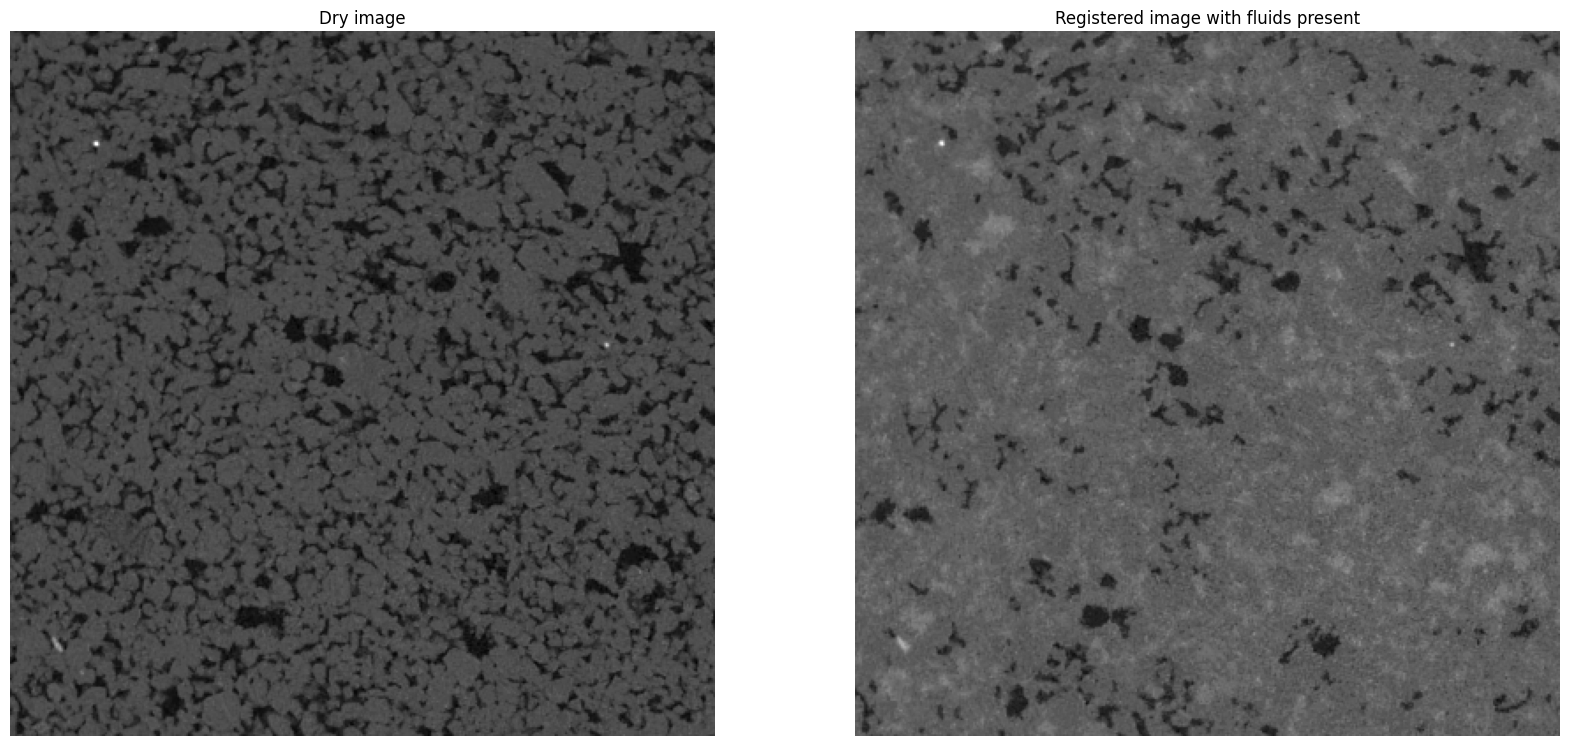

In [12]:

#Check the registration  
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 20),
                       sharex=True, sharey=True)

ax[0].imshow(denoise_dry[20,400:800, 400:800],cmap='gray')
ax[0].axis('off')
ax[0].set_title('Dry image')


ax[1].imshow(denoise_flow_reg[10,400:800, 400:800],cmap='gray')
ax[1].axis('off')
ax[1].set_title('Registered image with fluids present')
plt.show()




In [ ]:
# quick check to see if segmentation was successful 
seg_gas = utils.sanity_check(denoise_flow_reg.astype(np.uint8)[3, ...], filtered_gasv1[3, ...], 0.8)
plt.imshow(seg_gas[500:800, 500:800])
plt.show()

### Check the segmentation was successful 

In [28]:

z_widget = widgets.IntSlider(
    value=2,
    min=0,
    max=10,
    step=1,
)


overlay_widget = widgets.RadioButtons(
    options=[True, False],
    description='Overlay:',
    disabled=False,
)


def view_slice(img: np.ndarray, z: int, overlay: bool, mask: bool) -> None:
    depth, h, w = img.shape
    assert isinstance(img, np.ndarray)
    assert isinstance(z, int)
    assert isinstance(overlay, bool)
    assert 0 <= z < depth

    slice_o = img[z, :, :]

    if overlay:
        slice = utils.preprocess(slice_o)
        mask  = mask[z, :, :]
        slice = utils.sanity_check(slice, mask)


    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 20),
                       sharex=True, sharey=True)

    ax[0].imshow(slice,cmap='gray')
    ax[0].axis('off')


    ax[1].imshow(slice_o,cmap='gray')
    ax[1].axis('off')
    plt.show()



widgets.interact(view_slice, img=widgets.fixed(denoise_flow_reg[:, 300:1000,300:1000]), z=z_widget, overlay=overlay_widget, mask = widgets.fixed(masked_gas[:, 300:1000,300:1000]==0))

interactive(children=(IntSlider(value=2, description='z', max=10), RadioButtons(description='Overlay:', option…

<function __main__.view_slice(img: numpy.ndarray, z: int, overlay: bool, mask: bool) -> None>